In [2]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import time
import multiprocessing as mp
from tqdm import tqdm

# Import dos dados

In [3]:
# Parametros
file_path = '~/git/ls/input/BigBanco.xlsm'


# Import
df = pd.read_excel(file_path)
df.head()


,data,pares,ativo_dep,ativo_ind,dickey-fuller,adf,prop_financeiro,fisher,meia-vida,desvio-padrao,...,media_n,data_saida,in_dep,in,in.1,out,out.1,res,res.1,resultado
0,2015-01-02,ITSA4|BBDC3,5700,-1800,3,-4.289345,1.17,0.824511,19,-2.308486,...,0.052786,2015-01-09,6,4.77,13.27,4.86,13.61,513.0,-612.0,-99.0
1,2015-01-02,IGTA3|BRML3,1400,-1900,9,-6.626779,1.59,0.664409,12,-3.014527,...,0.281100,2015-01-05,2,21.20,9.63,21.71,9.22,714.0,779.0,1493.0
2,2015-01-02,RENT3|CCRO3,-2900,1700,4,-4.252567,1.42,0.480409,19,2.269341,...,-0.028646,2015-01-07,4,9.99,12.15,9.63,12.16,1044.0,17.0,1061.0
3,2015-01-02,JBSS3|TRPL4,2900,-3100,3,-4.028523,1.34,0.155227,16,-2.075095,...,0.149986,2015-01-09,6,9.90,6.98,9.56,6.62,-986.0,1116.0,130.0
4,2015-01-02,JBSS3|LAME4,3300,-1300,4,-4.370029,1.85,0.347030,19,-2.671004,...,0.066820,2015-01-09,6,9.90,13.67,9.56,13.33,-1122.0,442.0,-680.0


In [3]:
df.columns

Index(['data', 'pares', 'ativo_dep', 'ativo_ind', 'dickey-fuller', 'adf',
       'prop_financeiro', 'fisher', 'meia-vida', 'desvio-padrao', 'periodo',
       'ok', 'vol_financ', 'manter', 'variancia_beta', 'dagostino-person',
       'media_n', 'data_saida', 'in_dep', 'in', 'in.1', 'out', 'out.1', 'res',
       'res.1', 'resultado'],
      dtype='object')

In [4]:
# adiciona colunas auxiliares
df['pares_invertidos'] = df.pares.apply(lambda x: x[-x.find('|'):] +'|' + x[:x.find('|')] )

# corrige o ordenamento das colunas
df = df[['data', 'pares', 'pares_invertidos', 'ativo_dep', 'ativo_ind', 'dickey-fuller', 'adf',
       'prop_financeiro', 'fisher', 'meia-vida', 'desvio-padrao', 'periodo',
       'ok', 'vol_financ', 'manter', 'variancia_beta', 'dagostino-person',
       'media_n', 'data_saida', 'in_dep', 'in', 'in.1', 'out', 'out.1', 'res',
       'res.1', 'resultado']]



df.head()

,data,pares,pares_invertidos,ativo_dep,ativo_ind,dickey-fuller,adf,prop_financeiro,fisher,meia-vida,...,media_n,data_saida,in_dep,in,in.1,out,out.1,res,res.1,resultado
0,2015-01-02,ITSA4|BBDC3,BBDC3|ITSA4,5700,-1800,3,-4.289345,1.17,0.824511,19,...,0.052786,2015-01-09,6,4.77,13.27,4.86,13.61,513.0,-612.0,-99.0
1,2015-01-02,IGTA3|BRML3,BRML3|IGTA3,1400,-1900,9,-6.626779,1.59,0.664409,12,...,0.281100,2015-01-05,2,21.20,9.63,21.71,9.22,714.0,779.0,1493.0
2,2015-01-02,RENT3|CCRO3,CCRO3|RENT3,-2900,1700,4,-4.252567,1.42,0.480409,19,...,-0.028646,2015-01-07,4,9.99,12.15,9.63,12.16,1044.0,17.0,1061.0
3,2015-01-02,JBSS3|TRPL4,TRPL4|JBSS3,2900,-3100,3,-4.028523,1.34,0.155227,16,...,0.149986,2015-01-09,6,9.90,6.98,9.56,6.62,-986.0,1116.0,130.0
4,2015-01-02,JBSS3|LAME4,LAME4|JBSS3,3300,-1300,4,-4.370029,1.85,0.347030,19,...,0.066820,2015-01-09,6,9.90,13.67,9.56,13.33,-1122.0,442.0,-680.0


In [5]:
# Obtem o intervalo de tempo do dataset
data_inicio = df.data.min()
data_final = df.data.max()
print('Intervalo do dataset:{} a {}'.format(data_inicio, data_final))
print('Shape: {}'.format(df.shape))

Intervalo do dataset:2015-01-02 00:00:00 a 2020-07-14 00:00:00
Shape: (9324, 27)


# Operação de entrar e sair

In [6]:
def trade(dataset, data_inicial, data_final, portfolio_max_size):
    
    # Parametros de inicializacao
    df = dataset
    data = data_inicial

    portfolio = pd.DataFrame(data=None, columns=df.columns)

    operacoes = pd.DataFrame(data=None, columns=df.columns)
    
  
    # itera diariamente
    while data <= data_final:
        #####
        # SAIDA
        #####
        ativos_saindo = portfolio[portfolio['data_saida'] == data]
        ativos_saindo_index = set(ativos_saindo.index)

        #remove do portfolio
        portfolio_index = set(portfolio.index)
        portfolio = portfolio.loc[list(portfolio_index - ativos_saindo_index)]

        # registra as operacoes concluidas
        operacoes = operacoes.append(ativos_saindo)

        ####
        # ENTRADA
        ####
        # carrega todos ativos entrantes
        ativos_entrantes = df[df.data == data]

        # filtrar os pares não validos
        portfolio_pares = set(portfolio.pares_invertidos).union(set(portfolio.pares))

        ativos_entrantes_pares = set(ativos_entrantes.pares)

        ativos_entrantes = ativos_entrantes[ativos_entrantes.pares.isin(list(ativos_entrantes_pares - portfolio_pares))]


        # ordena os ativos elegíveis
        # TODO: segundo nível do sort
        ativos_entrantes = ativos_entrantes.sort_values(by = ['dickey-fuller'], ascending = False )


        # filtra de acordo com o tamanho maximo da carteira
        portfolio_slotes_disponiveis = portfolio_max_size - portfolio.shape[0]

        portfolio_slotes_disponiveis = portfolio_slotes_disponiveis if portfolio_slotes_disponiveis > 0 else 0

        ativos_entrantes = ativos_entrantes[:portfolio_slotes_disponiveis]


        # grava o novo portfolio 
        portfolio = portfolio.append(ativos_entrantes)

        data += pd.DateOffset(1)
        
    return(operacoes)

# Filtrar pelos parâmetros

In [7]:
def filter_dataframe(dataframe, parameters):
    
    df = dataframe
    
    param = parameters
    
    c1 = df['dickey-fuller'] >= param['dickey-fuller']
    c2 = df['fisher'] >= param['fisher']
    c3 = df['meia-vida'] <= param['meia-vida']
    c4 = df['media_n'].between(-param['media_n'],param['media_n'])
    c5 = (df['desvio-padrao'] <= - param['desvio-padrao']) | (df['desvio-padrao'] >= param['desvio-padrao']) 
    c6 = df['periodo'] >= param['periodo']
    c7 = df['variancia_beta'] <= param['variancia_beta']
    c8 = df['dagostino-person'] >= param['dagostino-person']
    
    
    df_filtered = df[c1 & c2 & c3 & c4 & c5 & c6 & c7 & c7]
    
    return(df_filtered)

# Métricas

In [8]:
def metrica_mdd(df, dotacao_inicial):
    
    resultado_acumulado = df.resultado.cumsum() + dotacao_inicial
    mdd = 0
    pico = resultado_acumulado.iloc[0]
    
    for i in resultado_acumulado:
        if i > pico:
            pico = i
        dd = (pico - i)/pico
        
        if dd > mdd:
            mdd = dd
    
    return round(mdd,3)

In [9]:
def metricas(df, dotacao_inicial):
    
    n_operacoes = df.shape[0]
    
    retorno = df.resultado.sum()
    
    win_rate = round(sum(df.resultado > 0)/df.shape[0], 2)
    
    pay_off = round(abs(df.resultado[df.resultado > 0].mean() / df.resultado[df.resultado < 0].mean()),3)
    
    mdd = metrica_mdd(df, dotacao_inicial)
    
    recovery_factor = round(abs(df.resultado[df.resultado > 0].sum() / df.resultado[df.resultado < 0].sum()),3)
    
    
    return ({'n_operacoes': n_operacoes,
            'retorno': retorno,
            'win_rate': win_rate,
            'pay_off': pay_off,
            'mdd': mdd,
            'recovery_factor':recovery_factor})

# Roda os trades

In [15]:
param = {'portfolio_max_size':10,
         'dickey-fuller': 8,
         'fisher': 0.3,
         'meia-vida': 100,
         'media_n': 0.5,
         'desvio-padrao': 2,
         'periodo': 100,
         'variancia_beta': 0.01,
         'dagostino-person': 0.05}

In [16]:
start_time = time.time()

df_filtered = filter_dataframe(df, param)

operacoes = trade(df_filtered, data_inicio, data_final, param['portfolio_max_size'])

tempo_trade = time.time() - start_time

print("--- %s seconds ---" % (tempo_trade))

--- 29.406118869781494 seconds ---


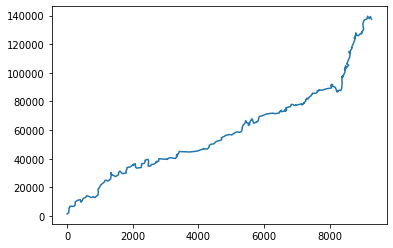

In [17]:
metricas(operacoes, 125000)
plt.plot(operacoes.resultado.cumsum())

# Grid Search

In [228]:
#ranges de valores
portfolio_max_size = np.arange(2,6,1)
dickey_fuller = np.arange(3,10,1)
fisher = np.arange(-0.5,1,0.1)
meia_vida = [10,25,100]
media_n = np.arange(0.5, 2, 0.1)
desvio_padrao = np.arange(2, 3.6, 0.1)
periodo = [100, 120, 140, 160, 180, 200, 220, 240, 250]
variancia_beta = np.arange(0.01, 0.11, 0.01)
dagostino_person = 0.05

In [265]:
#ranges de valores
portfolio_max_size = np.arange(2,3,1)
dickey_fuller = np.arange(3,4,1)
fisher = np.arange(-0.5,-0.4,0.1)
meia_vida = [10, 25]
media_n = np.arange(0.5, 0.6, 0.1)
desvio_padrao = np.arange(2, 2.1, 0.1)
periodo = [100]
variancia_beta = np.arange(0.01, 0.12, 0.1)
dagostino_person = 0.05

In [266]:
lista_parametros = list(itertools.product(portfolio_max_size, 
                                          dickey_fuller,
                                          fisher,
                                          meia_vida,
                                          media_n,
                                          desvio_padrao,
                                          periodo,
                                          variancia_beta ))


tempo_segundos = len(lista_parametros)*tempo_trade
tempo_horas = round(tempo_segundos/(60*60),2)
tempo_dias = round(tempo_segundos/(60*60*24),2)
tempo_anos = round(tempo_segundos/(60*60*24*365),2)

print('Número de iterações: {}'.format(len(lista_parametros)))
print('Tempo previsto de validação: {} anos'.format(tempo_anos))
print('Tempo previsto de validação: {} dias'.format(tempo_dias))
print('Tempo previsto de validação: {} horas'.format(tempo_horas))

Número de iterações: 8
Tempo previsto de validação: 0.0 anos
Tempo previsto de validação: 0.0 dias
Tempo previsto de validação: 0.07 horas


In [238]:
testes = []

for parametros in tqdm(lista_parametros[:2]):
    
    param = {'portfolio_max_size': parametros[0],
         'dickey-fuller': parametros[1],
         'fisher': parametros[2],
         'meia-vida': parametros[3],
         'media_n': parametros[4],
         'desvio-padrao': parametros[5],
         'periodo': parametros[6],
         'variancia_beta': parametros[7],
         'dagostino-person': 0.05}
    
    df_filtered = filter_dataframe(df, param)

    operacoes = trade(df_filtered, data_inicio, data_final, param['portfolio_max_size'])
    
    testes.append([param, metricas(operacoes, parametros[0]*25000)])

100%|██████████| 2/2 [01:03<00:00, 31.55s/it]


In [239]:
testes

[[{'portfolio_max_size': 2,
   'dickey-fuller': 3,
   'fisher': -0.5,
   'meia-vida': 10,
   'media_n': 0.5,
   'desvio-padrao': 2.0,
   'periodo': 100,
   'variancia_beta': 0.01,
   'dagostino-person': 0.05},
  {'n_operacoes': 469,
   'retorno': 39618.00000000012,
   'win_rate': 0.6,
   'pay_off': 0.81,
   'mdd': 1.027,
   'recovery_factor': 1.2}],
 [{'portfolio_max_size': 2,
   'dickey-fuller': 3,
   'fisher': -0.5,
   'meia-vida': 10,
   'media_n': 0.5,
   'desvio-padrao': 2.0,
   'periodo': 100,
   'variancia_beta': 0.02,
   'dagostino-person': 0.05},
  {'n_operacoes': 473,
   'retorno': 36324.00000000008,
   'win_rate': 0.59,
   'pay_off': 0.813,
   'mdd': 1.046,
   'recovery_factor': 1.179}]]

# Processamento Distribuído

## Setup

In [18]:
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


In [19]:
# escapsulando a função Sincrona

def back_test_sync(parametros, df = df, data_inicio = data_inicio, data_final =  data_final ):
    param = {'portfolio_max_size': parametros[0],
         'dickey-fuller': parametros[1],
         'fisher': parametros[2],
         'meia-vida': parametros[3],
         'media_n': parametros[4],
         'desvio-padrao': parametros[5],
         'periodo': parametros[6],
         'variancia_beta': parametros[7],
         'dagostino-person': 0.05}
    
    df_filtered = filter_dataframe(df, param)

    operacoes = trade(df_filtered, data_inicio, data_final, param['portfolio_max_size'])
    
    return([param, metricas(operacoes, parametros[0]*25000)])

In [20]:
# escapsulando a função Assincrona

def collect_result(result):
    '''Define callback function to collect the output in `results` '''
    global results
    results.append(result)


def back_test_async(i, parametros, df = df, data_inicio = data_inicio, data_final =  data_final ):
    param = {'portfolio_max_size': parametros[0],
         'dickey-fuller': parametros[1],
         'fisher': parametros[2],
         'meia-vida': parametros[3],
         'media_n': parametros[4],
         'desvio-padrao': parametros[5],
         'periodo': parametros[6],
         'variancia_beta': parametros[7],
         'dagostino-person': 0.05}
    
    df_filtered = filter_dataframe(df, param)

    operacoes = trade(df_filtered, data_inicio, data_final, param['portfolio_max_size'])
    
    return(i, [param, metricas(operacoes, parametros[0]*25000)])

## Definição do Grid de Parâmetros

In [21]:
#ranges de valores
portfolio_max_size = np.arange(2,3,1)
dickey_fuller = np.arange(3,4,1)
fisher = np.arange(-0.5,-0.4,0.1)
meia_vida = [10, 25, 50, 100]
media_n = np.arange(0.5, 0.6, 0.1)
desvio_padrao = np.arange(2, 2.1, 0.1)
periodo = [100]
variancia_beta = np.arange(0.01, 0.12, 0.1)
dagostino_person = 0.05


# Gera a combinação dos parâmetros
lista_parametros = list(itertools.product(portfolio_max_size, 
                                          dickey_fuller,
                                          fisher,
                                          meia_vida,
                                          media_n,
                                          desvio_padrao,
                                          periodo,
                                          variancia_beta))


tempo_segundos = len(lista_parametros)*tempo_trade
tempo_horas = round(tempo_segundos/(60*60),2)
tempo_dias = round(tempo_segundos/(60*60*24),2)
tempo_anos = round(tempo_segundos/(60*60*24*365),2)

print('Número de iterações: {}'.format(len(lista_parametros)))
print('Tempo previsto de validação: {} anos'.format(tempo_anos))
print('Tempo previsto de validação: {} dias'.format(tempo_dias))
print('Tempo previsto de validação: {} horas'.format(tempo_horas))

Número de iterações: 16
Tempo previsto de validação: 0.0 anos
Tempo previsto de validação: 0.01 dias
Tempo previsto de validação: 0.13 horas


## Processamento Síncrono

In [298]:
start_time = time.time()

# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# Step 2: `pool.apply` the `howmany_within_range()`
results = pool.map(back_test_sync, [parametros for parametros in lista_parametros])

                      
# Step 3: Don't forget to close
pool.close()


print("--- %s seconds ---" % (time.time() - start_time))

--- 127.72169184684753 seconds ---


## Processamento Assíncrono

In [22]:
results = []

start_time = time.time()

pool = mp.Pool(mp.cpu_count())

# Step 3: Use loop to parallelize
for i, parametros in enumerate(lista_parametros):
    pool.apply_async(back_test_async, args=(i, parametros, df, data_inicio, data_final), callback=collect_result)

# Step 4: Close Pool and let all the processes complete    
pool.close()
pool.join()  # postpones the execution of next line of code until all processes in the queue are done.

print("--- %s seconds ---" % (time.time() - start_time))

--- 120.01316714286804 seconds ---


In [294]:
results[1][1]

[{'portfolio_max_size': 2,
  'dickey-fuller': 3,
  'fisher': -0.5,
  'meia-vida': 10,
  'media_n': 0.5,
  'desvio-padrao': 2.0,
  'periodo': 100,
  'variancia_beta': 0.11,
  'dagostino-person': 0.05},
 {'n_operacoes': 474,
  'retorno': 35946.0000000001,
  'win_rate': 0.59,
  'pay_off': 0.799,
  'mdd': 1.071,
  'recovery_factor': 1.174}]